# Twitter Sentiment Analysis - 03 Preprocessing and Training Data

The objective of this notebook is to prepare data for fitting models. In notebook 02_Exploratory_Data_Analysis, we have already featured new columns for the stock data, measuring the changes each day. In this notebook, we will be using word embedding to convert words to vectors, then use that as an additional parameter to our training set. Word Embedding is a language modeling technique used for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions.

Guidance from Springboard:

Create dummy or indicator features for categorical variables \
Standardize the magnitude of numeric features using a scaler \
Split your data into testing and training datasets

**Link(s) to previous notebook(s)**: \
00_Historical_Data_2014: https://github.com/parisvu07/Springboard_Data_Science/tree/main/Capstone_2_Twitter_Sentiment_Analysis \
01_Data_Wrangling:
https://github.com/parisvu07/Springboard_Data_Science/blob/main/Capstone_2_Twitter_Sentiment_Analysis/01_Data_Wrangling.ipynb \
02_Exploratory_Data_Analysis: https://github.com/parisvu07/Springboard_Data_Science/blob/main/Capstone_2_Twitter_Sentiment_Analysis/02_Exploratory_Data_Analysis.ipynb

Quick fix for "Unable to render rich display": copy and paste the notebook link to https://nbviewer.org

## 3.1 Combining Dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re

import gensim
from gensim.models.doc2vec import TaggedDocument
LabeledSentence = gensim.models.doc2vec.TaggedDocument
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from nltk.tokenize import TweetTokenizer 

In [2]:
#Importing tweet data from previous notebook "02_Exploratory_Data_Analysis"
trading_hours_tweets = pd.read_csv('02_tweets_data.csv', lineterminator='\n')
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,Sentiment
0,2022-12-30,20:29:43,LlcBillionaire,0,Twitter Web App,10 New Year’s food traditions around the world,0.454545,0.136364,Positive,1.0
1,2022-12-30,20:29:32,skitontop1,0,Twitter Web App,Entries &amp; exits Daily! \nDiscord link belo...,0.500000,0.300000,Positive,1.0
2,2022-12-30,20:29:28,StockJobberOG,0,Twitter Web App,$AAPL $MSFT $SPY $TSLA $AMZN $BRK.B\n\n,0.000000,0.000000,Neutral,0.0
3,2022-12-30,20:29:11,LlcBillionaire,0,Twitter Web App,The biggest — and maybe the best — financial r...,0.150000,0.500000,Positive,1.0
4,2022-12-30,20:28:29,skitontop1,0,Twitter Web App,"#1 Chatroom interms of \n\nalert,calls,Analysi...",1.000000,0.600000,Positive,1.0


In [3]:
#Importing stock data from notebook "02_Exploratory_Data_Analysis"
eda_stock_data = pd.read_csv('02_stock_data.csv', encoding='latin-1')
eda_stock_data = eda_stock_data.set_index('Dates')
eda_stock_data = eda_stock_data.drop('Time', axis=1)
eda_stock_data.head()

,Adj Close,Volume,%_change_Open,%_change_High,%_change_Low,%_change_Close,%_change_Volume
Dates,,,,,,,
2022-12-01,148.309998,71250400,NaN,NaN,NaN,NaN,NaN
2022-12-02,147.809998,65447400,-1.518116,-0.757731,-0.654803,-0.337132,-8.144516
2022-12-05,146.630005,68826400,1.240064,1.972972,0.082396,-0.798317,5.162925
2022-12-06,142.910004,64727200,-0.473707,-2.398619,-2.641151,-2.536999,-5.955854
2022-12-07,140.940002,69721100,-3.318151,-2.668030,-1.352874,-1.378491,7.715304


## 3.1 Pre-processing: Stock Data

In [4]:
#renaming Volume to stock_volume
eda_stock_data = eda_stock_data.rename(columns={'Volume': 'stock_volume'})

#find twitter volume during trading hours
eda_stock_data['twitter_volume'] = trading_hours_tweets.groupby('Dates')['text'].count()

### 3.1.2 Binary Encoding

Creating a new columns to measure stock trend. If today change in price is greater than yesterday price, trend equals to 1. If it is less than, stock trend equals 0. 

In [5]:
#Create a new columns representing trends
RISE = 1
FALL = 0

#Make a copy of the eda_stock_data dataset
stock_data = eda_stock_data.copy()
stock_data['open_trend'] = np.where(stock_data['%_change_Open'] > 0, RISE, FALL)
stock_data['high_trend'] = np.where(stock_data['%_change_High'] > 0, RISE, FALL)
stock_data['low_trend'] = np.where(stock_data['%_change_Low'] > 0, RISE, FALL)
stock_data['close_trend'] = np.where(stock_data['%_change_Close'] > 0, RISE, FALL)
stock_data['volume_trend'] = np.where(stock_data['%_change_Volume'] > 0, RISE, FALL)

#Drop unnecessary columns
stock_data = stock_data.drop(['%_change_Open','%_change_High','%_change_Low','%_change_Close','%_change_Volume'], axis=1)

stock_data.head()

,Adj Close,stock_volume,twitter_volume,open_trend,high_trend,low_trend,close_trend,volume_trend
Dates,,,,,,,,
2022-12-01,148.309998,71250400,1451,0,0,0,0,0
2022-12-02,147.809998,65447400,1551,0,0,0,0,0
2022-12-05,146.630005,68826400,1738,1,1,1,0,1
2022-12-06,142.910004,64727200,2072,0,0,0,0,0
2022-12-07,140.940002,69721100,1912,0,0,0,0,1


Next, we will combine the twitter dataframe and stock dataframe to find the overall sentiment at the end of each trading day

In [6]:
combined_tweets = trading_hours_tweets.groupby('Dates').mean()
combined_tweets

,likes,Subjectivity,Polarity,Sentiment
Dates,,,,
2022-12-01,3.358270,0.341031,0.166630,0.418668
2022-12-02,2.422508,0.336724,0.179263,0.434727
2022-12-03,4.091234,0.338026,0.092043,0.075134
2022-12-04,5.201709,0.351474,0.212572,0.491453
2022-12-05,16.589788,0.285005,0.119601,0.320138
2022-12-06,3.363636,0.308533,0.138852,0.345839
2022-12-07,3.910183,0.306545,0.141816,0.385379
2022-12-08,2.735952,0.323832,0.177100,0.450755
2022-12-09,2.080395,0.317647,0.172363,0.416784


In [7]:
merged_dataframes = pd.merge(stock_data, combined_tweets, left_index=True, right_index=True)
merged_dataframes

,Adj Close,stock_volume,twitter_volume,open_trend,high_trend,low_trend,close_trend,volume_trend,likes,Subjectivity,Polarity,Sentiment
Dates,,,,,,,,,,,,
2022-12-01,148.309998,71250400,1451,0,0,0,0,0,3.358270,0.341031,0.166630,0.418668
2022-12-02,147.809998,65447400,1551,0,0,0,0,0,2.422508,0.336724,0.179263,0.434727
2022-12-05,146.630005,68826400,1738,1,1,1,0,1,16.589788,0.285005,0.119601,0.320138
2022-12-06,142.910004,64727200,2072,0,0,0,0,0,3.363636,0.308533,0.138852,0.345839
2022-12-07,140.940002,69721100,1912,0,0,0,0,1,3.910183,0.306545,0.141816,0.385379
2022-12-08,142.649994,62128300,1649,1,1,1,1,0,2.735952,0.323832,0.177100,0.450755
2022-12-09,142.160004,76097000,1415,0,1,0,0,1,2.080395,0.317647,0.172363,0.416784
2022-12-12,144.490005,70462700,1441,1,0,1,1,0,2.265884,0.307966,0.150830,0.387431
2022-12-13,145.470001,93886200,1860,1,1,1,1,1,2.004828,0.317893,0.169065,0.425966


In [8]:
#Rearranging the columns
merged_dataframes = merged_dataframes[["Adj Close", 'stock_volume', 'twitter_volume',
                                      'likes', 'Subjectivity', 'Polarity', 'Sentiment',
                                      'open_trend', 'high_trend', 'low_trend', 'close_trend',
                                       'volume_trend']]
merged_dataframes

,Adj Close,stock_volume,twitter_volume,likes,Subjectivity,Polarity,Sentiment,open_trend,high_trend,low_trend,close_trend,volume_trend
Dates,,,,,,,,,,,,
2022-12-01,148.309998,71250400,1451,3.358270,0.341031,0.166630,0.418668,0,0,0,0,0
2022-12-02,147.809998,65447400,1551,2.422508,0.336724,0.179263,0.434727,0,0,0,0,0
2022-12-05,146.630005,68826400,1738,16.589788,0.285005,0.119601,0.320138,1,1,1,0,1
2022-12-06,142.910004,64727200,2072,3.363636,0.308533,0.138852,0.345839,0,0,0,0,0
2022-12-07,140.940002,69721100,1912,3.910183,0.306545,0.141816,0.385379,0,0,0,0,1
2022-12-08,142.649994,62128300,1649,2.735952,0.323832,0.177100,0.450755,1,1,1,1,0
2022-12-09,142.160004,76097000,1415,2.080395,0.317647,0.172363,0.416784,0,1,0,0,1
2022-12-12,144.490005,70462700,1441,2.265884,0.307966,0.150830,0.387431,1,0,1,1,0
2022-12-13,145.470001,93886200,1860,2.004828,0.317893,0.169065,0.425966,1,1,1,1,1


In [9]:
#Assigning "Positive", "Neutral", or "Negative" sentiment to each trading day
#A stock at 0.0 sentiment does not neccesarily mean positive or negative. So we will give a 0.05 buffer
POSITIVE_SENTIMENT_THRESHOLD = 0.05 
NEGATIVE_SENTIMENT_THRESHOLD = -0.05

sentiments = []
for sentiment_score in merged_dataframes['Polarity']:
    if sentiment_score >= POSITIVE_SENTIMENT_THRESHOLD:
        sentiments.append('Positive')
    elif sentiment_core <= NEGATIVE_SENTIMENT_THRESHOLD:
        sentiments.append('Negative')
    else:
        sentiments.append('Neutral')
        
#Creating a new column by adding the newly created sentiment list
merged_dataframes['Sentiment_Score'] = sentiments
merged_dataframes['Sentiment_Score'].value_counts()

/var/folders/v3/zfqmnfxs5z3dkfs5cn70l8bh0000gn/T/ipykernel_23220/2814748260.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_dataframes['Sentiment_Score'] = sentiments


Positive    21
Name: Sentiment_Score, dtype: int64

## 3.2. Pre-processing: Twitter Data

In [10]:
#Importing tweet data from previous notebook "02_Exploratory_Data_Analysis"
trading_hours_tweets = pd.read_csv('02_tweets_data.csv', encoding='latin-1')
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,Sentiment
0,2022-12-30,20:29:43,LlcBillionaire,0,Twitter Web App,10 New Yearâs food traditions around the world,0.454545,0.136364,Positive,1.0
1,2022-12-30,20:29:32,skitontop1,0,Twitter Web App,Entries &amp; exits Daily! \nDiscord link belo...,0.500000,0.300000,Positive,1.0
2,2022-12-30,20:29:28,StockJobberOG,0,Twitter Web App,$AAPL $MSFT $SPY $TSLA $AMZN $BRK.B\n\n,0.000000,0.000000,Neutral,0.0
3,2022-12-30,20:29:11,LlcBillionaire,0,Twitter Web App,The biggest â and maybe the best â financi...,0.150000,0.500000,Positive,1.0
4,2022-12-30,20:28:29,skitontop1,0,Twitter Web App,"#1 Chatroom interms of \n\nalert,calls,Analysi...",1.000000,0.600000,Positive,1.0


In [11]:
trading_hours_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118345 entries, 0 to 118344
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Dates         118345 non-null  object 
 1   Time          118345 non-null  object 
 2   user          118345 non-null  object 
 3   likes         118345 non-null  int64  
 4   source        118345 non-null  object 
 5   text          118026 non-null  object 
 6   Subjectivity  118345 non-null  float64
 7   Polarity      118345 non-null  float64
 8   Analysis      118345 non-null  object 
 9   Sentiment     118345 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 9.0+ MB


In [12]:
trading_hours_tweets.dtypes

Dates            object
Time             object
user             object
likes             int64
source           object
text             object
Subjectivity    float64
Polarity        float64
Analysis         object
Sentiment       float64
dtype: object

In [13]:
trading_hours_tweets['text'] = trading_hours_tweets['text'].values.astype(str)
trading_hours_tweets['text'].dtypes

dtype('O')

In [14]:
trading_hours_tweets[trading_hours_tweets.isna().any(axis=1)]
trading_hours_tweets.dropna()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,Sentiment
0,2022-12-30,20:29:43,LlcBillionaire,0,Twitter Web App,10 New Yearâs food traditions around the world,0.454545,0.136364,Positive,1.0
1,2022-12-30,20:29:32,skitontop1,0,Twitter Web App,Entries &amp; exits Daily! \nDiscord link belo...,0.500000,0.300000,Positive,1.0
2,2022-12-30,20:29:28,StockJobberOG,0,Twitter Web App,$AAPL $MSFT $SPY $TSLA $AMZN $BRK.B\n\n,0.000000,0.000000,Neutral,0.0
3,2022-12-30,20:29:11,LlcBillionaire,0,Twitter Web App,The biggest â and maybe the best â financi...,0.150000,0.500000,Positive,1.0
4,2022-12-30,20:28:29,skitontop1,0,Twitter Web App,"#1 Chatroom interms of \n\nalert,calls,Analysi...",1.000000,0.600000,Positive,1.0
...,...,...,...,...,...,...,...,...,...,...
118340,2022-12-29,13:30:02,whitestone_UK,0,Buffer,iPhone 14 Pro WhiteStone Dome Glass BEST Glass...,0.300000,1.000000,Positive,1.0
118341,2022-12-29,13:30:02,NicheMktMedia,0,Buffer,What Are The Best Apple IPhone Cases,0.300000,1.000000,Positive,1.0
118342,2022-12-29,13:30:01,BooknewsGoods_j,0,bookbotgoods,ãåªè¡å»»æ¦ãæ°çã°ããº\n\nãiPhone...,0.000000,0.000000,Neutral,0.0
118343,2022-12-29,13:30:00,konyamoentame,2,Twitter for iPhone,ã¾ããªã23æããï¼\n\nã¨ãã¨ã ã²ã...,0.000000,0.000000,Neutral,0.0


### 3.2.1 Counts


Text Mining is the process of deriving meaningful information from natural language text. Natural Language Processing (NLP) is a part of computer science and artificial intelligence which deals with human languages.

In [15]:
#Count the number of characters present in a tweet.
def count_chars(text):
    return len(text)

#Count the number of words present in each line of tweet
def count_words(text):
    return len(str(text).split())

#Count the number of punctuation
import string
def count_punctuations(text):
    punctuations = string.punctuation
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

#Count the number of words in quotation marks
def count_words_in_quotes(text):
    x = re.findall(('.'|"."), text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count
    
#Count the number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

#Count the number of unique words
def count_unique_words(text):
    return len(set(text.split()))

#Count of hashtags
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x)

#Count of mentions
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

#Count of stopwords
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

Implementations

In [16]:
trading_hours_tweets['char_count'] = trading_hours_tweets["text"].apply(lambda x:count_chars(x))
trading_hours_tweets['word_count'] = trading_hours_tweets["text"].apply(lambda x:count_words(x))
trading_hours_tweets['sent_count'] = trading_hours_tweets["text"].apply(lambda x:count_sent(x))
trading_hours_tweets['stopword_count'] = trading_hours_tweets["text"].apply(lambda x:count_stopwords(x))
trading_hours_tweets['unique_word_count'] = trading_hours_tweets["text"].apply(lambda x:count_unique_words(x))
trading_hours_tweets['htag_count'] = trading_hours_tweets["text"].apply(lambda x:count_htags(x))
trading_hours_tweets['mention_count'] = trading_hours_tweets["text"].apply(lambda x:count_mentions(x))
trading_hours_tweets['punct_count'] = trading_hours_tweets["text"].apply(lambda x:count_punctuations(x))

In [17]:
#Count of average word length
trading_hours_tweets['avg_wordlength'] = trading_hours_tweets['char_count']/trading_hours_tweets['word_count']

#Count of average sentence length
trading_hours_tweets['avg_sentlength'] = trading_hours_tweets['word_count']/trading_hours_tweets['sent_count']

#Ratio of unique words to total word count
trading_hours_tweets['unique_vs_words'] = trading_hours_tweets['unique_word_count']/trading_hours_tweets['word_count']

#Ratio of stopwords to total word count
trading_hours_tweets['stopwords_vs_words'] = trading_hours_tweets['stopword_count']/trading_hours_tweets['word_count']

In [18]:
trading_hours_tweets['avg_wordlength'] = trading_hours_tweets['char_count']/trading_hours_tweets['word_count']
trading_hours_tweets['avg_sentlength'] = trading_hours_tweets['word_count']/trading_hours_tweets['sent_count']
trading_hours_tweets['unique_vs_words'] = trading_hours_tweets['unique_word_count']/trading_hours_tweets['word_count']
trading_hours_tweets['stopwords_vs_words'] = trading_hours_tweets['stopword_count']/trading_hours_tweets['word_count']

### 3.2.2 Tokenization

Here we turn our twitter strings to lists of individual tokens (words, punctuations). Tokenization is the first step in NLP. It is the process of breaking strings into tokens which in turn are small structures or units. Tokenization involves three steps which are breaking a complex sentence into words, understanding the importance of each word with respect to the sentence and finally produce structural description on an input sentence.

Performing a simple pre-processing step, like removing links, removing user name, numbers, double space, punctuation, lower casing, etc.

In [19]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'httpS+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RTs@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet
my_punctuation = string.punctuation
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+ my_punctuation + ']+',' ', sent) # strip punctuation
    sent = re.sub('s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: remove_links(x))
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: remove_users(x))
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: preprocess(x))

In [20]:
from nltk.tokenize import RegexpTokenizer

#NLTK tokenizer
tokenizer = RegexpTokenizer(r'\w+')
trading_hours_tweets['tokens'] = trading_hours_tweets['clean_text'].apply(tokenizer.tokenize)

### 3.2.3 Sentence Length

Using the tokens that we generated, we want to explore sentence length and vocabulary size

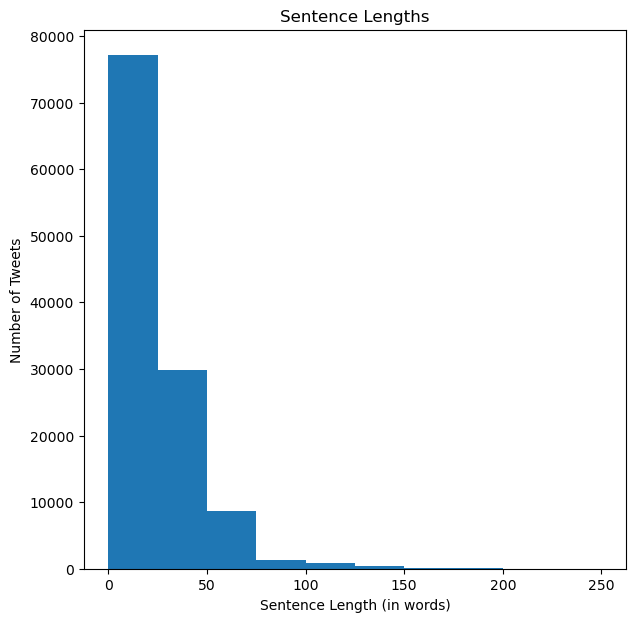

In [21]:
sentence_lengths = [len(tokens) for tokens in trading_hours_tweets['tokens']]
vocab = sorted(list(set([word for tokens in trading_hours_tweets['tokens'] for word in tokens])))

plt.figure(figsize = (7,7))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [22]:
print('We have a vocabulary size of', len(vocab), 'unique words')

We have a vocabulary size of 69595 unique words


### 3.2.4 Removing Stopwords

“Stop words” are the most common words in a language like “the”, “a”, “at”, “for”, “above”, “on”, “is”, “all”. These words do not provide any meaning and are usually removed from texts. We can remove these stop words using nltk library

In [23]:
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
trading_hours_tweets['tweet_without_stopwords'] = trading_hours_tweets['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### 3.2.5 Lemmitization

In simpler terms, lemmitization is the process of converting a word to its base form. Lemmatization considers the context and converts the word to its meaningful base form. For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care'. This is extremely valuable because we want to identify key words that lead to negative, positive and neutral sentiments.

In [24]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

trading_hours_tweets['tweet_lemmatized'] = trading_hours_tweets['tweet_without_stopwords'].apply(lemmatize_text)

## 3.3 Feature Elimination

The purpose of combining dataframes is to view the correlation between each features. We will perform feature "elimination" to help reduce chances of overfitting and running into the curse of dimensionality. First, let's take the average of any quantitative features for tweets data and group by date

In [25]:
combined_tweets = trading_hours_tweets.groupby('Dates').mean()
combined_tweets

,likes,Subjectivity,Polarity,Sentiment,char_count,word_count,sent_count,stopword_count,unique_word_count,htag_count,mention_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
Dates,,,,,,,,,,,,,,,
2022-12-01,3.358270,0.341031,0.166630,0.418668,100.757721,16.600549,1.557310,3.254633,15.575841,0.004118,0.000686,6.372672,12.049550,0.965350,0.181359
2022-12-02,2.422508,0.336724,0.179263,0.434727,113.843087,18.862379,1.588424,3.132476,17.597428,0.008360,0.001929,6.375284,13.648532,0.958254,0.157363
2022-12-03,4.091234,0.338026,0.092043,0.075134,112.824687,18.883721,1.468694,3.973166,17.989267,0.005367,0.003578,6.167987,14.192446,0.971405,0.192076
2022-12-04,5.201709,0.351474,0.212572,0.491453,95.766667,15.696581,1.541026,3.264957,15.006838,0.002564,0.000000,6.393567,11.143895,0.974668,0.185375
2022-12-05,16.589788,0.285005,0.119601,0.320138,115.483075,19.387263,1.627080,3.428571,17.832473,0.005164,0.001147,6.170603,14.333762,0.953386,0.169452
2022-12-06,3.363636,0.308533,0.138852,0.345839,117.055796,19.382876,1.623858,3.460798,18.024050,0.004329,0.000962,6.449587,14.343542,0.955374,0.171255
2022-12-07,3.910183,0.306545,0.141816,0.385379,114.448564,18.791645,1.570235,3.127415,17.406789,0.007833,0.000522,6.797870,14.048140,0.957784,0.158489
2022-12-08,2.735952,0.323832,0.177100,0.450755,113.382477,18.572205,1.534743,3.213897,17.500906,0.003021,0.001208,6.383359,13.919566,0.964881,0.167848
2022-12-09,2.080395,0.317647,0.172363,0.416784,114.167137,19.081805,1.656559,3.277856,17.773625,0.004231,0.000000,6.234835,13.920813,0.958580,0.169155


In [26]:
#Merging tweets with stock adj. closing price. By default, merging will perform an inner join
stock_tweets_data = pd.merge(eda_stock_data['Adj Close'], combined_tweets, left_index=True, right_index=True)
stock_tweets_data

,Adj Close,likes,Subjectivity,Polarity,Sentiment,char_count,word_count,sent_count,stopword_count,unique_word_count,htag_count,mention_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
Dates,,,,,,,,,,,,,,,,
2022-12-01,148.309998,3.358270,0.341031,0.166630,0.418668,100.757721,16.600549,1.557310,3.254633,15.575841,0.004118,0.000686,6.372672,12.049550,0.965350,0.181359
2022-12-02,147.809998,2.422508,0.336724,0.179263,0.434727,113.843087,18.862379,1.588424,3.132476,17.597428,0.008360,0.001929,6.375284,13.648532,0.958254,0.157363
2022-12-05,146.630005,16.589788,0.285005,0.119601,0.320138,115.483075,19.387263,1.627080,3.428571,17.832473,0.005164,0.001147,6.170603,14.333762,0.953386,0.169452
2022-12-06,142.910004,3.363636,0.308533,0.138852,0.345839,117.055796,19.382876,1.623858,3.460798,18.024050,0.004329,0.000962,6.449587,14.343542,0.955374,0.171255
2022-12-07,140.940002,3.910183,0.306545,0.141816,0.385379,114.448564,18.791645,1.570235,3.127415,17.406789,0.007833,0.000522,6.797870,14.048140,0.957784,0.158489
2022-12-08,142.649994,2.735952,0.323832,0.177100,0.450755,113.382477,18.572205,1.534743,3.213897,17.500906,0.003021,0.001208,6.383359,13.919566,0.964881,0.167848
2022-12-09,142.160004,2.080395,0.317647,0.172363,0.416784,114.167137,19.081805,1.656559,3.277856,17.773625,0.004231,0.000000,6.234835,13.920813,0.958580,0.169155
2022-12-12,144.490005,2.265884,0.307966,0.150830,0.387431,113.308011,18.600829,1.589088,3.350829,17.397790,0.004144,0.003453,6.312471,13.675862,0.959889,0.173349
2022-12-13,145.470001,2.004828,0.317893,0.169065,0.425966,109.073498,17.900751,1.527361,3.267167,16.837446,0.004292,0.002146,6.362918,13.450632,0.964431,0.176030


### 3.3.1 Correlation in Stock Data

Understanding how the features in a dataset interact with each other is crucial when deciding which features to use in a model. There are many ways to construct a model that is effective and accurate. One of the fastest ways to strengthen a model is to identify and reduce the features in the dataset that are highly correlated. Correlated features will add noise and inaccuracy to a model, which in turn will make it harder to achieve the desired outcome.

Highly correlated variables should be avoided when creating models is because they can skew the output. If there are two independent variables that are representing the same occurrence (i.e SqFt of a house vs bedrooms in a house) it can create “noise” or inaccuracy in the model. Models rely solely on outside information in order to create a useful output and having colinear (correlated) variables can create an inflated variance in at least one of the regression outputs. 

Text(0.5, 1.0, 'Multi-Collinearity of Stock Features')

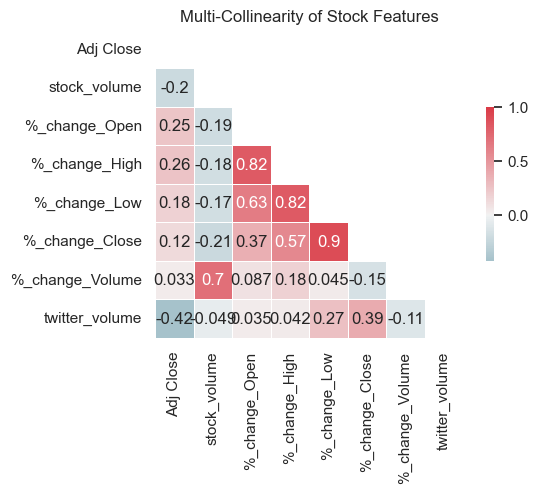

In [27]:
#Correlation heatmap for stock data
sns.set(style="white")

# Create a covariance matrix
corr = eda_stock_data.corr()

# Creating a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6,4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot=True,mask=mask,cmap=cmap,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5})
ax.set_title('Multi-Collinearity of Stock Features')

No block has siginifacant high correlation

### 3.3.3 Correlation on Tweets Data

Text(0.5, 1.0, 'Multi-Collinearity of Stock Features')

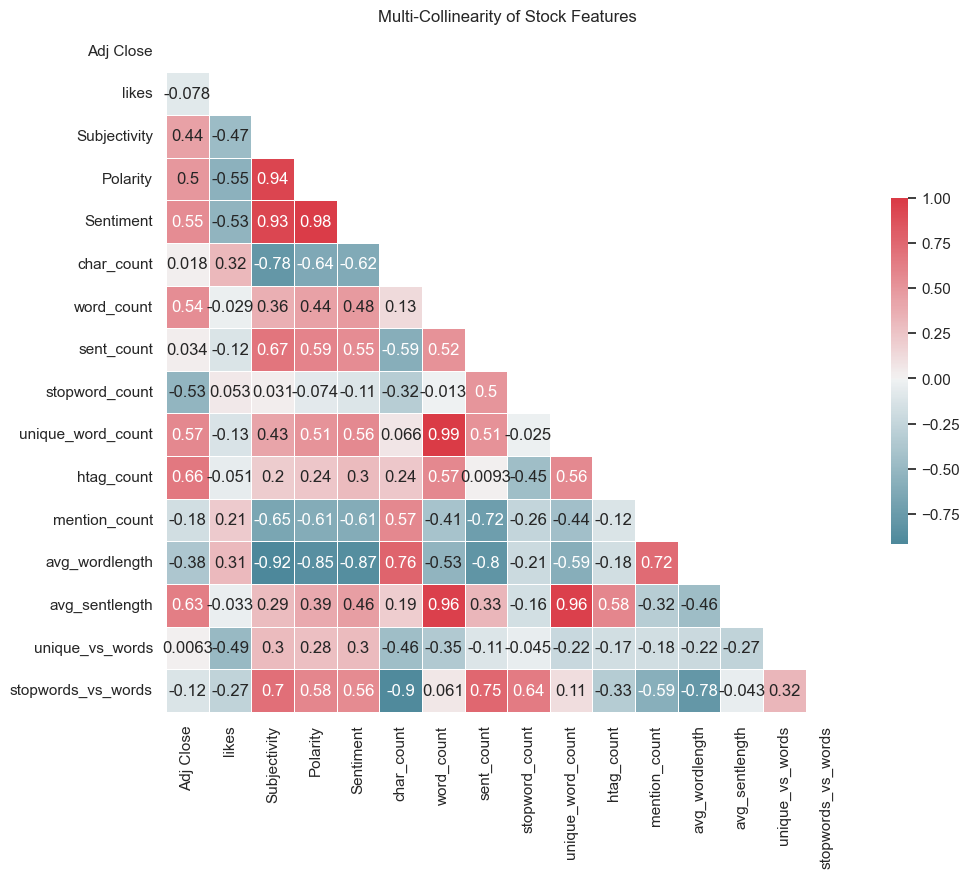

In [28]:
#Correlation heatmap for tweets data + adj. closing price
sns.set(style="white")

# Create a covariance matrix
corr = stock_tweets_data.corr()

# Creating a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot=True,mask=mask,cmap=cmap,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5})
ax.set_title('Multi-Collinearity of Stock Features')

As the maps above shows, as the color becomes darker in either direction (red or blue) that means that those variables are more highly correlated and should not be paired together in the same model. With that said, since our y is Adj. Close, we need to eliminate any features that are highly correlated to Adj. Close. 

In [29]:
#Dropping columns with correlation higher and lower than 0.50 and -0.50
trading_hours_tweets = trading_hours_tweets.drop(['likes', 'stopword_count', 'stopwords_vs_words'], axis=1)
trading_hours_tweets.columns

Index(['Dates', 'Time', 'user', 'source', 'text', 'Subjectivity', 'Polarity',
       'Analysis', 'Sentiment', 'char_count', 'word_count', 'sent_count',
       'unique_word_count', 'htag_count', 'mention_count', 'punct_count',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words', 'clean_text',
       'tokens', 'tweet_without_stopwords', 'tweet_lemmatized'],
      dtype='object')

## 3.4 Text Classification

One of the features that we will be using to predict the adjusted closing price is the vectorized representation of the tweet. To get the numbers, we need to build a text classification model using word embedding.

**Text classification** can be applied to many different problems, including gauging the public opinion on social media. Historically, it is studied as news articles classification into a pre-determined set of classes, and based on the summary or the title or even the whole body of the article the machine learning models determine if the news article is about economy, sports, real state, and so on. It can also be used for classifying a company's documents into categories that will be analyzed only by the corresponding department. Finally, it can direct, for example, quantify public opinions by classifying the query of a ticker, allowing to gauge public sentiments and lead to accurate price prediction.

**Word embedding** is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Loosely speaking, they are vector representations of a particular word. In this project, we will use Word2Vec embedding method to map a word to a fixed-length vector. In simple terms, words that have similar meanings or are related closely, when mapped into a vector space would appear closer, like in a cluster. This can help us understand the semantics of the words in a sentence better than any previously mentioned technique.

Text classfication models performed in this project are Bags of words, TF-IDF, Word2Vec and BERT.

In [30]:
#checking gensim version
gensim.__version__

'4.3.0'

In [31]:
#exploring pre-trained sets
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


### 3.4.1 Testing Pre-Trained Vector Sets

***Let's first look at the glove-twitter-200 pre-trained set***

#loading one of the pre-trained vectors \
wv = api.load('glove-twitter-200')

#Loading pre-trained vector can take minutes, so we can also save it using the function below \
wv.save('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/glove-twitter-200.kv')

In [32]:
#and load it whenever we need it 
from gensim.models import KeyedVectors 
wv = KeyedVectors.load('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/glove-twitter-200.kv')

In [33]:
print(wv['apple'])

#200 meaning there are 200 dimensional
print(len(wv['apple']))

[ 2.1537e-01 -1.7943e-01 -1.0945e-01  7.7789e-02 -6.9670e-01  5.1510e-01
  1.5756e-01 -9.5902e-01  4.0594e-01 -5.4547e-01 -3.7913e-02  3.3253e-01
 -9.0614e-01 -4.1216e-01 -4.9564e-01  2.7421e-01  2.8665e-01  6.5473e-01
 -5.8499e-03 -1.1103e-01  1.1077e-02 -9.3015e-02 -1.3340e-02  1.1900e-01
 -7.0752e-02 -3.2651e-01  3.0276e-01 -2.0905e-01 -1.1087e+00 -7.5981e-03
 -1.3988e-01  2.8975e-01 -3.4486e-01 -7.5653e-01  7.8638e-01  1.4151e-02
  6.8262e-01  6.3894e-01 -1.2569e-01  5.0341e-01 -2.6714e-01  2.7174e-01
 -8.7672e-01  1.1315e-01  5.1526e-01 -3.0609e-01  1.6206e-01  3.2633e-01
 -3.6483e-01 -4.1779e-01  3.8487e-02  1.0097e-01 -6.3430e-01  2.9925e-01
  1.6298e-01  4.5842e-02  6.8611e-01  1.4584e-01 -2.6317e-01 -1.2730e-01
 -3.1738e-02 -5.7886e-01  4.8199e-01  2.9078e-01  9.3583e-02 -3.1432e-01
  9.8402e-01  2.3303e-01  3.0066e-01 -6.2141e-01 -1.4641e-01 -1.2452e-01
  4.5778e-01 -5.1290e-02 -9.1132e-01 -8.6348e-01  2.4460e-01 -5.2860e-01
  5.9676e-01  2.7645e-01  8.5135e-01  9.7477e-02  3

***Let's now look at the word2vec-google-news-300 pre-trained set***

#downloading from database \
wv2 = api.load('word2vec-google-news-300')

#saving \
wv2.save('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/word2vec-google-news-300.kv')

In [34]:
#loading to notebook
wv2 = KeyedVectors.load('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/word2vec-google-news-300.kv')

In [35]:
#let's try and see the similarity between apple and tesla using both loaded sets
print("Using glove-twitter-200 pre-trained set, the similarity between apple and tesla are", wv.similarity('apple', 'tesla'))
print("Using word2vec-google-300 pre-trained set, the similarity between apple and tesla are", wv2.similarity('apple', 'tesla'))

Using glove-twitter-200 pre-trained set, the similarity between apple and tesla are 0.33980334
Using word2vec-google-300 pre-trained set, the similarity between apple and tesla are 0.08046864


Looks like the Word2Vec set does not really understand "apple" here stands for the corporate name Apple Inc. It is totally understandable since one of the weaknesses of Word2Vec is that it does not take into consideration the context of the sentence

In [36]:
#But if we compare apple and mango as fruit names
print("Using glove-twitter-200 pre-trained set, the similarity between apple and mango are", wv.similarity('apple', 'mango'))
print("Using word2vec-google-300 pre-trained set, the similarity between apple and mango are", wv2.similarity('apple', 'mango'))

Using glove-twitter-200 pre-trained set, the similarity between apple and mango are 0.4747994
Using word2vec-google-300 pre-trained set, the similarity between apple and mango are 0.5751856


In [37]:
#But if we compare two different entities
print("Using glove-twitter-200 pre-trained set, the similarity between apple and car are", wv.similarity('apple', 'car'))
print("Using word2vec-google-300 pre-trained set, the similarity between apple and car are", wv2.similarity('apple', 'car'))

Using glove-twitter-200 pre-trained set, the similarity between apple and car are 0.3703842
Using word2vec-google-300 pre-trained set, the similarity between apple and car are 0.12830707


In [38]:
pairs = [
    ('car', 'minivan'),
    ('car', 'bicycle'),
    ('car', 'airplane'),
    ('car', 'cereal'),
    ('car', 'communism')
]

print("Using twitter-200")
for w1, w2 in pairs:
    print("%r\t%r\t%.2f" % (w1, w2, wv.similarity(w1, w2)))
    
print("Using google-300")
for w1, w2 in pairs:
    print("%r\t%r\t%.2f" % (w1, w2, wv2.similarity(w1, w2)))

Using twitter-200
'car'	'minivan'	0.40
'car'	'bicycle'	0.47
'car'	'airplane'	0.46
'car'	'cereal'	0.27
'car'	'communism'	0.06
Using google-300
'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


From testing a few pairs of text, we can see that the glove-200 pretrained set has higher accuracy for stock-related keyword, while the google-300 pre-trained set has higher accuracy for common pairs. Thus, we will use the glove-200 pre-trained set for the models.

In [39]:
#Creating a function to vectorize the tokens
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr +=1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [ ]:
trading_hours_tweets['vec'] = trading_hours_tweets['tweet_lemmatized'].apply(sent_vec)

In [ ]:
trading_hours_tweets.head()

### 3.4.2 Train Test Split

In [ ]:
X = trading_hours_tweets['vec'].to_list()
y = trading_hours_tweets['Sentiment'].to_list()

X[0]

In [ ]:
#performing train test split on data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## 3.5 Saving

In [ ]:
trading_hours_tweets.to_csv('03_tweets_data.csv', index=False)
eda_stock_data.to_csv('03_stock_data.csv', index=False)